# **CVPS20 // Assignment 5**

assigned : **Nov 10, 2020**

DUE : **Nov 18, 2020 11:59pm**

## Identifying High Quality Scanning Probe Microscopy Images

<img src="https://www.icmm.csic.es/spmage/gallery/2007/view/view_2741246073812.jpg" width=250x>

---

Scanning probe microscopy is a technique used to study the surfaces of materials at atomic scales via the interactions of the surface with the material on the tip of the probe (metaphorically like the needle on a record player).  The interactions at the surface include currents induced in the probe via quantum tunneling (referred to as "Scanning Tunneling Microscopy") or atomic forces ("Atomic Force Microscopy").  That is, unlike more macroscopic scale microscopes, these scanning probe microscopes interact directly with the surface material.  The resultant images are often degraded due to probe defects, poor probe/surface interactions, or other artifacts.  Determining a "good" scan from a "bad" scan is a time consuming process for the microscope operator and so automated classification of scans can form a useful basis for automatic microscope operations.

For context to this assignment, read through this recent paper in Nature by [Krull et al. (2020)](https://www.nature.com/articles/s42005-020-0317-3#data-availability), in which the authors propose a two part system for automating a scanning probe microscope by first automatically detecting "bad" scans via a convolutional neural network and then adjusting the scan strategy (and probe repair) via a second learning stage.  In this assignment you will tackle the first part of this process, using a CNN to distinguish "good" scans from "bad" scans.

<b>

Rules for homeworks:

1. You may work with other students in the class, but if you do, each student with whom you worked <u>must</u> be listed in this notebook in the first cell below.  Direct copying from someone else's notebook is not permitted.

2. All solutions and outputs must be derived with python and the notebook should be "runable" by me (top to bottom) without errors.

3. Late homeworks will assess a 15% late penalty up to 3 days after the due date and a 50% late penalty until the end of the term (see CVPS20 syllabus).

</b>

<u>**Instructions for tasks that will be graded are in bold below.**</u>

---

**Please list the names of the other students with whom you worked for this assignment (if none, put "None").**

None

In the folder `spm/` in `cvps20/data/` there are four files consisting of a training set of good and bad scans and a testing set of good and bad scans.  **Load the training and testing sets into numpy arrays and provide visualizations of examples of both "good" and "bad" scans.**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report


In [3]:
TestBad = np.load('/content/drive/MyDrive/cvps20/data/spm/test_bad_all.npy')
TestGood = np.load('/content/drive/MyDrive/cvps20/data/spm/test_good_all.npy')
TrainBad = np.load('/content/drive/MyDrive/cvps20/data/spm/train_bad_all.npy')
TrainGood = np.load('/content/drive/MyDrive/cvps20/data/spm/train_good_all.npy')

In [4]:
TestBad.shape

(1478, 64, 64)

In [5]:
TestGood.shape

(459, 64, 64)

In [6]:
TrainBad.shape

(4350, 64, 64)

In [7]:
TrainGood.shape

(1302, 64, 64)

Text(0.5, 1.0, 'An example of a good scan')

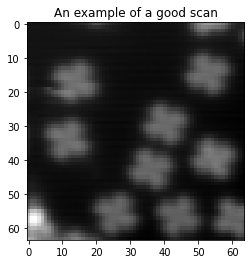

In [8]:
plt.imshow(TrainGood[10], cmap = 'gist_gray')
plt.title('An example of a good scan')

Text(0.5, 1.0, 'An example of a bad scan')

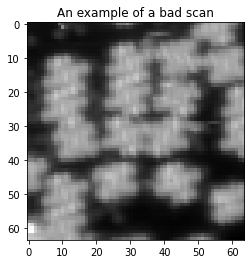

In [9]:
plt.imshow(TrainBad[10], cmap = 'gist_gray')
plt.title('An example of a bad scan')

**Normalize each image (good and bad, training and testing) so that its pixel values are in the range `0` to `1` without using any `for` loops.$^{\dagger}$**

<small> $^{\dagger}$ note, normalizing the data in this way is essential for the next steps</small>

In [10]:
#As the values of the matrices are negative, add a value to make them positive, then normalize.

Min = TrainGood.min(axis=2).min(axis=1) #Find out the minimum value for each figure.
MinMatrix = np.repeat(np.repeat(Min.reshape(TrainGood.shape[0],1,1), 64, axis=1),64, axis=2) #Reapeat the max value to make a matrix the same size as the original figure.
TrainGoodPositive = TrainGood - MinMatrix #Shift the values to positive

Max = TrainGoodPositive.max(axis=2).max(axis=1) #Find out the maximum value for each figure.
MaxMatrix = np.repeat(np.repeat(Max.reshape(TrainGood.shape[0],1,1), 64, axis=1),64, axis=2) #Reapeat the max value to make a matrix the same size as the original figure.

TrainGoodNorm = TrainGoodPositive/MaxMatrix
print(TrainGoodNorm.max(axis=2).max(axis=1))
print(TrainGoodNorm.min(axis=2).min(axis=1))

[1. 1. 1. ... 1. 1. 1.]
[0. 0. 0. ... 0. 0. 0.]


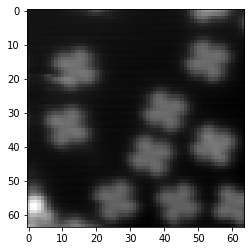

In [11]:
plt.imshow(TrainGoodNorm[10], cmap='gist_gray')

In [12]:
#For TrainBad

Min = TrainBad.min(axis=2).min(axis=1) #Find out the minimum value for each figure.
MinMatrix = np.repeat(np.repeat(Min.reshape(TrainBad.shape[0],1,1), 64, axis=1),64, axis=2) #Reapeat the max value to make a matrix the same size as the original figure.
TrainBadPositive = TrainBad - MinMatrix #Shift the values to positive

Max = TrainBadPositive.max(axis=2).max(axis=1) #Find out the maximum value for each figure.
MaxMatrix = np.repeat(np.repeat(Max.reshape(TrainBad.shape[0],1,1), 64, axis=1),64, axis=2) #Reapeat the max value to make a matrix the same size as the original figure.

TrainBadNorm = TrainBadPositive/MaxMatrix

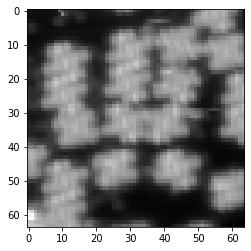

In [13]:
plt.imshow(TrainBadNorm[10], cmap='gist_gray')

In [14]:
# For TestGood

Min = TestGood.min(axis=2).min(axis=1) #Find out the minimum value for each figure.
MinMatrix = np.repeat(np.repeat(Min.reshape(TestGood.shape[0],1,1), 64, axis=1),64, axis=2) #Reapeat the max value to make a matrix the same size as the original figure.
TestGoodPositive = TestGood - MinMatrix #Shift the values to positive

Max = TestGoodPositive.max(axis=2).max(axis=1) #Find out the maximum value for each figure.
MaxMatrix = np.repeat(np.repeat(Max.reshape(TestGood.shape[0],1,1), 64, axis=1),64, axis=2) #Reapeat the max value to make a matrix the same size as the original figure.

TestGoodNorm = TestGoodPositive/MaxMatrix

In [15]:
# For TestBad

Min = TestBad.min(axis=2).min(axis=1) #Find out the minimum value for each figure.
MinMatrix = np.repeat(np.repeat(Min.reshape(TestBad.shape[0],1,1), 64, axis=1),64, axis=2) #Reapeat the max value to make a matrix the same size as the original figure.
TestBadPositive = TestBad - MinMatrix #Shift the values to positive

Max = TestBadPositive.max(axis=2).max(axis=1) #Find out the maximum value for each figure.
MaxMatrix = np.repeat(np.repeat(Max.reshape(TestBad.shape[0],1,1), 64, axis=1),64, axis=2) #Reapeat the max value to make a matrix the same size as the original figure.

TestBadNorm = TestBadPositive/MaxMatrix

Note, there are more "bad" training examples than "good" training examples.  As we discussed in class, this has the potential to be detrimental for a variety of reasons.  **Create a balanced training set in which the number or "good" training examples is equal to the number of "bad" training examples by randomly subselecting the same number of "bad" examples as there are "good" examples (a technique known as "undersampling").**

In [16]:
#Generate indeces and shuffle

Index = list(range(TrainBad.shape[0]))
random.shuffle(Index)
TrainBadIndex = np.asarray(Index)

Index = list(range(TrainGood.shape[0]))
random.shuffle(Index)
TrainGoodIndex = np.asarray(Index)

Index = list(range(TestBad.shape[0]))
random.shuffle(Index)
TestBadIndex = np.asarray(Index)

Index = list(range(TestGood.shape[0]))
random.shuffle(Index)
TestGoodIndex = np.asarray(Index)

In [17]:
#Take 1000 from TrainGood, 1000 from TrainBad, 250 from TestGood, 250 from TestBad

FeatTr = np.concatenate((TrainGoodNorm[TrainGoodIndex[0:1000]], TrainBadNorm[TrainBadIndex[0:1000]]), axis=0)
FeatTe = np.concatenate((TestGoodNorm[TestGoodIndex[0:250]], TestBadNorm[TestBadIndex[0:250]]), axis=0)

FeatTr = FeatTr.reshape(FeatTr.shape[0], FeatTr.shape[1], FeatTr.shape[2], 1)
FeatTe = FeatTe.reshape(FeatTe.shape[0], FeatTe.shape[1], FeatTe.shape[2], 1)


TargTr = np.concatenate((np.full(1000, 1), np.full(1000, 0)))
TargTe = np.concatenate((np.full(250, 1), np.full(250, 0))) #1 for good, 0 for bad. 

In [18]:
FeatTr.shape

(2000, 64, 64, 1)

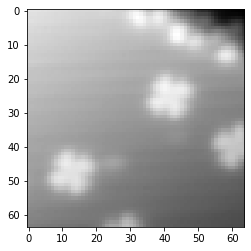

In [19]:
plt.imshow(FeatTr[600,:,:,0], cmap='gist_gray')

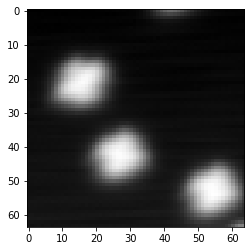

In [20]:
plt.imshow(FeatTr[1600,:,:,0], cmap='gist_gray')

**Train a convolutional neural network that differentiates between "good" and "bad" scans.  Be sure to maximize accuracy while minimizing overfitting.  Note, there are <u>many</u> things to consider here including how to determine if the model is overfit, model performance assessment, validation sets, model architecture, fitting routine parameters, *etc*.**

In [28]:
layer1 = keras.layers.Conv2D(4, (15,15), activation="relu", input_shape=(64, 64, 1))
layer2 = keras.layers.MaxPool2D((5, 5))
layer3 = keras.layers.Flatten()
layer4 = keras.layers.Dense(10, activation="relu")
layer5 = keras.layers.Dense(2, activation="softmax")

layers = [layer1, layer2, layer3, layer4, layer5]

In [29]:
model = keras.Sequential(layers)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [38]:
history = model.fit(FeatTr, TargTr, epochs=200, batch_size=100, verbose=1)

Epoch 1/200
20/20 [==============================] - 0s 6ms/step - loss: 0.5781 - accuracy: 0.6965
Epoch 2/200
20/20 [==============================] - 0s 6ms/step - loss: 0.5774 - accuracy: 0.7005
Epoch 3/200
20/20 [==============================] - 0s 6ms/step - loss: 0.5687 - accuracy: 0.7000
Epoch 4/200
20/20 [==============================] - 0s 6ms/step - loss: 0.5678 - accuracy: 0.6990
Epoch 5/200
20/20 [==============================] - 0s 6ms/step - loss: 0.5630 - accuracy: 0.7000
Epoch 6/200
20/20 [==============================] - 0s 6ms/step - loss: 0.5611 - accuracy: 0.7005
Epoch 7/200
20/20 [==============================] - 0s 6ms/step - loss: 0.5536 - accuracy: 0.7055
Epoch 8/200
20/20 [==============================] - 0s 6ms/step - loss: 0.5468 - accuracy: 0.7105
Epoch 9/200
20/20 [==============================] - 0s 6ms/step - loss: 0.5396 - accuracy: 0.7160
Epoch 10/200
20/20 [==============================] - 0s 6ms/step - loss: 0.5342 - accuracy: 0.7190
Epoch 11/

In [39]:
 loss_tr, acc_tr = model.evaluate(FeatTr, TargTr, batch_size=1, verbose=0)
loss_te, acc_te = model.evaluate(FeatTe, TargTe, batch_size=1, verbose=0)

print("Training accuracy : {0:.4f}".format(acc_tr))
print("Testing accuracy  : {0:.4f}".format(acc_te))

Training accuracy : 0.9550
Testing accuracy  : 0.6180


In [ ]:
# -- define the layers
layer1 = keras.layers.Conv2D(4, (10,10), activation="relu", input_shape=(64, 64, 1))
layer2 = keras.layers.MaxPool2D((2, 2))
layer3 = keras.layers.Conv2D(64, (5, 5), activation="relu")
layer4 = keras.layers.MaxPool2D((2, 2))
layer5 = keras.layers.Flatten()
layer6 = keras.layers.Dense(1024, activation="relu")
layer7 = keras.layers.Dense(1, activation='sigmoid')
layer8 = keras.activations.sigmoid()

layers = [layer1, layer2, layer3, layer4, layer5, layer6, layer7, layer8]

# -- instantiate the model
model = keras.Sequential(layers)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# -- fit the model
history = model.fit(FeatTr, TargTr, epochs=50, batch_size=500, verbose=1)

# -- evaluate the training and testing accuracy
loss_tr, acc_tr = model.evaluate(FeatTr, TargTr, batch_size=1, verbose=0)
loss_te, acc_te = model.evaluate(FeatTe, TargTe, batch_size=1, verbose=0)

print("Training accuracy : {0:.4f}".format(acc_tr))
print("Testing accuracy  : {0:.4f}".format(acc_te))

TypeError: ignored

In [46]:
a = np.random.rand(5,5)

a

array([[0.58610422, 0.10918662, 0.28377942, 0.92695292, 0.5107373 ],
       [0.54796677, 0.46364644, 0.97763971, 0.97232602, 0.70811464],
       [0.73245273, 0.42255137, 0.46772363, 0.7926945 , 0.60666473],
       [0.05836539, 0.76843593, 0.64120265, 0.87351306, 0.06574085],
       [0.3807393 , 0.94616185, 0.48393219, 0.9759035 , 0.94857252]])

In [48]:
a.min(keepdims=True)

array([[0.05836539]])

In [49]:
a.min()

0.05836539266134855

In [51]:
a.min(keepdims=True) == a.min(keepdims=True)

array([[ True]])

In [41]:
a = np.arange(1,8)
a

array([1, 2, 3, 4, 5, 6, 7])